- [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- 時系列データの予測

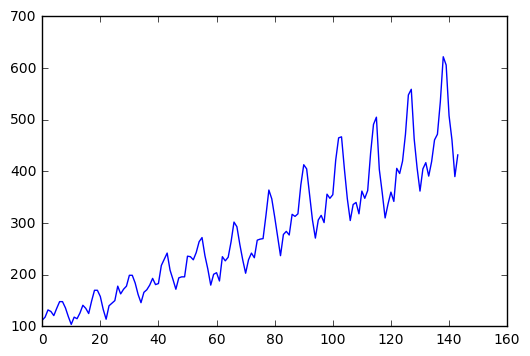

In [12]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('data/international-airline-passengers.csv',
                          usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [13]:
dataset

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121
5,135
6,148
7,148
8,136
9,119


## データセットの作成

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [15]:
# 再現性を担保するために固定したほうがよい
np.random.seed(7)

In [17]:
# load the dataset
dataframe = pandas.read_csv('data/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
type(dataframe), type(dataset)
dataset = dataset.astype('float32')

In [18]:
dataset.shape

(144, 1)

- 活性化関数にsigmoidやtanhを使うときは入力のスケールに大きな影響をうける
- 入力は[0, 1]に正規化するとよい
- scikit-learnの`MinMaxScaler`が便利

In [20]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [21]:
dataset[:10]

array([[ 0.01544401],
       [ 0.02702703],
       [ 0.05405405],
       [ 0.04826255],
       [ 0.03281853],
       [ 0.05984557],
       [ 0.08494207],
       [ 0.08494207],
       [ 0.06177607],
       [ 0.02895753]], dtype=float32)

In [77]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

96 48


- 1つ前の時刻tの値から次の時刻t+1の値を予測するのが課題
- (t)と(t+1)の値のペアを訓練データとする
- Xの方はlook_back（いくつ前まで使うか）によて複数の値があるため2次元配列になる

In [103]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [104]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [105]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(94, 1)
(94,)
(46, 1)
(46,)


- `trainX`は (samples, features) の配列
- LSTMでは入力を (samples, time steps, features) の配列にする必要がある
- look_backが大きい場合は入力が系列であるがfeaturesと考える？

In [106]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [107]:
print(trainX.shape)
print(testX.shape)

(94, 1, 1)
(46, 1, 1)


## LSTMの訓練

- LSTMはRNNの一種
- BPTT (Backpropagation Through Time) で訓練する
- LSTMは最近のシーケンスを記憶できる Memory Block を使う

- Forgate Gate: 記憶から何を捨て去るかを決める
- Input Gate: 記憶状態を更新するための入力からの値を決める
- Output Gate: 入力と記憶状態から何を出力するかを決める

In [57]:
model = Sequential()
# input_shape=(input_length, input_dim)
# look_back次元の系列長1のデータが入力、出力は4次元ベクトル
# 系列長1なので記憶は使われない？ LSTMに入れたらすぐ出てくる
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.0320
Epoch 2/100
0s - loss: 0.0143
Epoch 3/100
0s - loss: 0.0112
Epoch 4/100
0s - loss: 0.0102
Epoch 5/100
0s - loss: 0.0093
Epoch 6/100
0s - loss: 0.0084
Epoch 7/100
0s - loss: 0.0076
Epoch 8/100
0s - loss: 0.0068
Epoch 9/100
0s - loss: 0.0060
Epoch 10/100
0s - loss: 0.0053
Epoch 11/100
0s - loss: 0.0045
Epoch 12/100
0s - loss: 0.0039
Epoch 13/100
0s - loss: 0.0035
Epoch 14/100
0s - loss: 0.0031
Epoch 15/100
0s - loss: 0.0027
Epoch 16/100
0s - loss: 0.0025
Epoch 17/100
0s - loss: 0.0023
Epoch 18/100
0s - loss: 0.0022
Epoch 19/100
0s - loss: 0.0022
Epoch 20/100
0s - loss: 0.0021
Epoch 21/100
0s - loss: 0.0020
Epoch 22/100
0s - loss: 0.0021
Epoch 23/100
0s - loss: 0.0021
Epoch 24/100
0s - loss: 0.0021
Epoch 25/100
0s - loss: 0.0021
Epoch 26/100
0s - loss: 0.0021
Epoch 27/100
0s - loss: 0.0021
Epoch 28/100
0s - loss: 0.0021
Epoch 29/100
0s - loss: 0.0020
Epoch 30/100
0s - loss: 0.0020
Epoch 31/100
0s - loss: 0.0021
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

## 予測

In [108]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [109]:
# 出力は正規化されているため元のスケールに戻す
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

In [110]:
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [111]:
print(trainPredict.shape, trainY.shape)
print(testPredict.shape, testY.shape)

(94, 1) (1, 94)
(46, 1) (1, 46)


In [112]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 22.86 RMSE


In [113]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 47.80 RMSE


## 結果をプロット

In [114]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

In [115]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

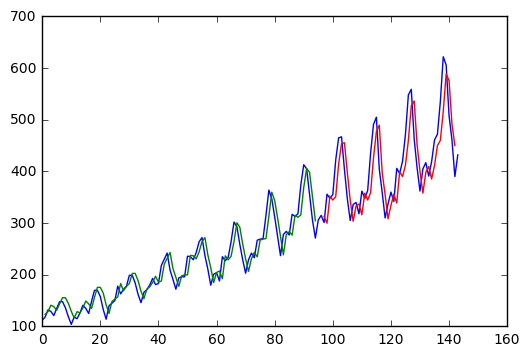

In [119]:
# 元データをプロット（青）
plt.plot(scaler.inverse_transform(dataset))

# 訓練内データの予測をプロット（緑）
plt.plot(trainPredictPlot)

# テストデータの予測をプロット
plt.plot(testPredictPlot)

## Windows Size

- 過去の3つ分のデータ（t-2, t-1, t) から次のデータ (t+1) を予測する
- このやり方では過去のデータを系列ではなく次元長として扱う（次元長は固定）

In [120]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [121]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(92, 3)
(92,)
(44, 3)
(44,)


In [122]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(testX.shape)

(92, 1, 3)
(44, 1, 3)


- 系列長は1のままで入力次元を3としている

In [123]:
model = Sequential()
# input_shape=(input_length, input_dim)
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.0474
Epoch 2/100
0s - loss: 0.0180
Epoch 3/100
0s - loss: 0.0125
Epoch 4/100
0s - loss: 0.0109
Epoch 5/100
0s - loss: 0.0096
Epoch 6/100
0s - loss: 0.0086
Epoch 7/100
0s - loss: 0.0077
Epoch 8/100
0s - loss: 0.0067
Epoch 9/100
0s - loss: 0.0061
Epoch 10/100
0s - loss: 0.0056
Epoch 11/100
0s - loss: 0.0052
Epoch 12/100
0s - loss: 0.0050
Epoch 13/100
0s - loss: 0.0048
Epoch 14/100
0s - loss: 0.0046
Epoch 15/100
0s - loss: 0.0044
Epoch 16/100
0s - loss: 0.0044
Epoch 17/100
0s - loss: 0.0043
Epoch 18/100
0s - loss: 0.0042
Epoch 19/100
0s - loss: 0.0041
Epoch 20/100
0s - loss: 0.0041
Epoch 21/100
0s - loss: 0.0042
Epoch 22/100
0s - loss: 0.0040
Epoch 23/100
0s - loss: 0.0038
Epoch 24/100
0s - loss: 0.0040
Epoch 25/100
0s - loss: 0.0038
Epoch 26/100
0s - loss: 0.0037
Epoch 27/100
0s - loss: 0.0038
Epoch 28/100
0s - loss: 0.0037
Epoch 29/100
0s - loss: 0.0037
Epoch 30/100
0s - loss: 0.0035
Epoch 31/100
0s - loss: 0.0034
Epoch 32/100
0s - loss: 0.0035
Epoch 33/100
0s -

In [124]:
# 予測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 元のスケールに戻す
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.73 RMSE
Test Score: 43.32 RMSE


- WindowSize=1より少し改善した！

## 入力を特徴ではなく系列として扱うアプローチ

- 過去の観測を別々の入力特徴量として表現するのではなく、入力特徴量の系列として使用することができます
- これは実際に問題の正確な枠組みになります
- 入力の系列3の間はLSTMが記憶している？
- 系列長を変えられる？（0パディング？）

In [132]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# [samples, time steps, features]
# 3次元の系列長1のデータ => 1次元の系列長3のデータ
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [134]:
print(trainX.shape, testX.shape)

(92, 3, 1) (44, 3, 1)


In [135]:
model = Sequential()
# input_shape=(input_length, input_dim)
# 入力データの次元が1で系列長がlook_backになった！
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
2s - loss: 0.0059
Epoch 2/100
1s - loss: 0.0044
Epoch 3/100
1s - loss: 0.0041
Epoch 4/100
1s - loss: 0.0037
Epoch 5/100
1s - loss: 0.0037
Epoch 6/100
1s - loss: 0.0034
Epoch 7/100
1s - loss: 0.0033
Epoch 8/100
1s - loss: 0.0032
Epoch 9/100
1s - loss: 0.0032
Epoch 10/100
1s - loss: 0.0032
Epoch 11/100
1s - loss: 0.0031
Epoch 12/100
1s - loss: 0.0031
Epoch 13/100
1s - loss: 0.0032
Epoch 14/100
1s - loss: 0.0032
Epoch 15/100
1s - loss: 0.0033
Epoch 16/100
1s - loss: 0.0032
Epoch 17/100
1s - loss: 0.0031
Epoch 18/100
1s - loss: 0.0032
Epoch 19/100
1s - loss: 0.0033
Epoch 20/100
1s - loss: 0.0031
Epoch 21/100
1s - loss: 0.0031
Epoch 22/100
1s - loss: 0.0031
Epoch 23/100
1s - loss: 0.0030
Epoch 24/100
1s - loss: 0.0030
Epoch 25/100
1s - loss: 0.0030
Epoch 26/100
1s - loss: 0.0031
Epoch 27/100
1s - loss: 0.0031
Epoch 28/100
1s - loss: 0.0031
Epoch 29/100
1s - loss: 0.0031
Epoch 30/100
1s - loss: 0.0032
Epoch 31/100
1s - loss: 0.0030
Epoch 32/100
1s - loss: 0.0030
Epoch 33/100
1s -

In [136]:
# 予測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 元のスケールに戻す
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.25 RMSE
Test Score: 57.85 RMSE


- 結果はちょっと悪化した・・・

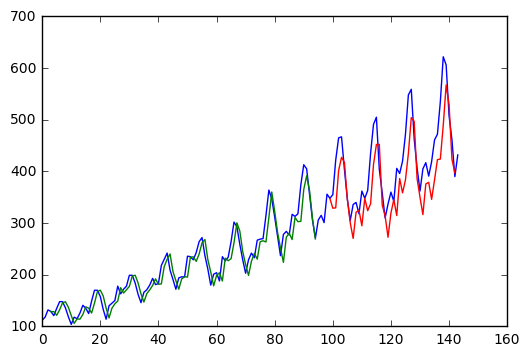

In [137]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

# 元データをプロット（青）
plt.plot(scaler.inverse_transform(dataset))

# 訓練内データの予測をプロット（緑）
plt.plot(trainPredictPlot)

# テストデータの予測をプロット
plt.plot(testPredictPlot)

## LSTMの内部状態

- Kerasのデフォルトでは各訓練バッチで内部状態がリセットされる
- また`predict()`や`evaluate()`を呼ぶたびにリセットされる
- statefulにすることで訓練中はずっと内部状態を維持することができる

```python
# LSTMオブジェクトの作成
model.add(LSTM(4,
               batch_input_shape=(batch_size, time_steps, features), 
               stateful=True)

# 訓練ループの書き方
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

# 予測の仕方
model.predict(trainX, batch_size=batch_size)
```

- LSTM作成時に`stateful=True`を指定する
- `batch_input_shape`でバッチサイズなどの情報も追加する
- `fit`時は`shuffle=False`にする
- 各エポックの最後で明示的に`reset_states()`する
- `predict`時も`batch_size`を与える

In [145]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# [samples, time steps, features]
# 3次元の系列長1のデータ => 1次元の系列長3のデータ
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [146]:
batch_size = 1

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
2s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0071
Epoch 1/1
0s - loss: 0.0056
Epoch 1/1
0s - loss: 0.0049
Epoch 1/1
0s - loss: 0.0046
Epoch 1/1
0s - loss: 0.0045
Epoch 1/1
0s - loss: 0.0044
Epoch 1/1
0s - loss: 0.0043
Epoch 1/1
0s - loss: 0.0043
Epoch 1/1
0s - loss: 0.0043
Epoch 1/1
0s - loss: 0.0042
Epoch 1/1
0s - loss: 0.0042
Epoch 1/1
0s - loss: 0.0042
Epoch 1/1
0s - loss: 0.0042
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0040
Epoch 1/1
0s - loss: 0.0040
Epoch 1/1
0s - loss: 0.0040
Epoch 1/1
0s - loss: 0.0040
Epoch 1/1
0s - loss: 0.0040
Epoch 1/1
0s - loss: 0.0039
Epoch 1/1
0s - loss: 0.0039
Epoch 1/1
0s - loss: 0.0039
Epoch 1/1
0s - loss: 0.0039
Epoch 1/1
0s - loss: 0.0039
Epoch 1/1
0s - loss: 0.0038
Epoch 1/1
0s - loss: 0.0038
Epoch 1/1
0s - loss: 0.0038
Epoch 1/1
0s - loss: 0.0038
Epoch 1/1
0s - loss: 0.0037
Epoch 1/1
0s - loss: 0.0037
Epoch 1/1
0s - loss: 0.0037
Epoch 1/1
0s - loss:

Train Score: 22.97 RMSE
Test Score: 50.51 RMSE


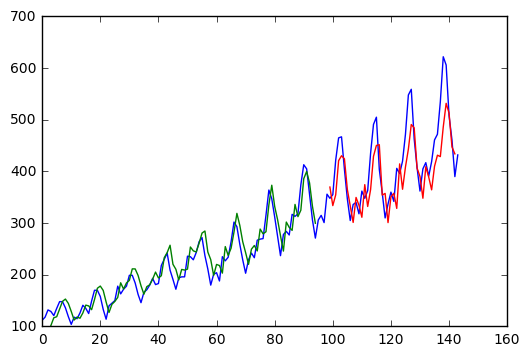

In [147]:
# 予測
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)

# 元のスケールに戻す
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

# 元データをプロット（青）
plt.plot(scaler.inverse_transform(dataset))

# 訓練内データの予測をプロット（緑）
plt.plot(trainPredictPlot)

# テストデータの予測をプロット
plt.plot(testPredictPlot)

## Stacked LSTM

- LSTMを複数つなげることができる
- 1つ前のLSTMが最終出力ではなく出力の系列を返す必要がある
- `return_sequences=True`とする

```python
model.add(LSTM(4,
               batch_input_shape=(batch_size, look_back, 1),
               stateful=True,
               return_sequences=True))
model.add(LSTM(4,
               batch_input_shape=(batch_size, look_back, 1),
               stateful=True))
```

In [148]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# [samples, time steps, features]
# 3次元の系列長1のデータ => 1次元の系列長3のデータ
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 1

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True,
               return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
4s - loss: 0.0049
Epoch 1/1
1s - loss: 0.0139
Epoch 1/1
1s - loss: 0.0119
Epoch 1/1
1s - loss: 0.0104
Epoch 1/1
1s - loss: 0.0092
Epoch 1/1
1s - loss: 0.0083
Epoch 1/1
1s - loss: 0.0077
Epoch 1/1
1s - loss: 0.0073
Epoch 1/1
1s - loss: 0.0069
Epoch 1/1
1s - loss: 0.0067
Epoch 1/1
1s - loss: 0.0065
Epoch 1/1
1s - loss: 0.0064
Epoch 1/1
1s - loss: 0.0063
Epoch 1/1
1s - loss: 0.0062
Epoch 1/1
1s - loss: 0.0061
Epoch 1/1
1s - loss: 0.0060
Epoch 1/1
1s - loss: 0.0059
Epoch 1/1
1s - loss: 0.0058
Epoch 1/1
1s - loss: 0.0057
Epoch 1/1
1s - loss: 0.0057
Epoch 1/1
1s - loss: 0.0056
Epoch 1/1
1s - loss: 0.0055
Epoch 1/1
1s - loss: 0.0055
Epoch 1/1
1s - loss: 0.0054
Epoch 1/1
1s - loss: 0.0053
Epoch 1/1
1s - loss: 0.0053
Epoch 1/1
1s - loss: 0.0052
Epoch 1/1
1s - loss: 0.0052
Epoch 1/1
1s - loss: 0.0051
Epoch 1/1
1s - loss: 0.0050
Epoch 1/1
1s - loss: 0.0050
Epoch 1/1
1s - loss: 0.0049
Epoch 1/1
1s - loss: 0.0049
Epoch 1/1
1s - loss: 0.0048
Epoch 1/1
1s - loss: 0.0048
Epoch 1/1
1s - loss:

Train Score: 22.90 RMSE
Test Score: 53.89 RMSE


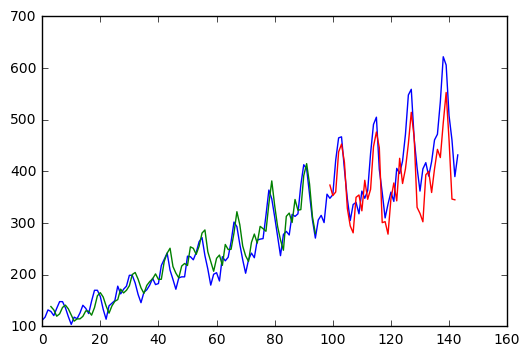

In [149]:
# 予測
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)

# 元のスケールに戻す
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

# 元データをプロット（青）
plt.plot(scaler.inverse_transform(dataset))

# 訓練内データの予測をプロット（緑）
plt.plot(trainPredictPlot)

# テストデータの予測をプロット
plt.plot(testPredictPlot)